In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spam-and-ham-dataset/test_spam.csv
/kaggle/input/spam-and-ham-dataset/train_spam.csv


# Imports

In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy
from spacy.util import minibatch
from spacy.training.example import Example

import random
from tqdm import tqdm
from IPython import display
from IPython.display import clear_output

from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.preprocessing import MaxAbsScaler

# Prepare data

In [3]:
_spam_test = pd.read_csv('/kaggle/input/spam-and-ham-dataset/test_spam.csv')
_spam_train = pd.read_csv('/kaggle/input/spam-and-ham-dataset/train_spam.csv')

In [5]:
_spam_train.head(10)

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...
5,spam,i am so greatful to mrs valerie dodson for hel...
6,ham,url url date not supplied government employees...
7,spam,welcome to jefferson pilot s gateway to wealth...
8,ham,looks like your ham corpus by and large has to...
9,ham,how are you with moneyas in to youmoney aint a...


In [7]:
_spam_train.groupby('text_type').count()

,text
text_type,
ham,11469
spam,4809


In [10]:
_spam_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


In [14]:
_spam_train.text_type[_spam_train.text_type == 'ham'] = 0
_spam_train.text_type[_spam_train.text_type == 'spam'] = 1
_spam_train.groupby('text_type').count()

,text
text_type,
0,11469
1,4809


In [58]:
SEED = 42
BATCH_SIZE = 32

In [159]:
X_train, X_test, y_train, y_test = train_test_split(_spam_train['text'],
                                                    _spam_train['text_type'],
                                                    test_size=0.3,
                                                    random_state=SEED)

# Модели на n-граммах

In [177]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(X_train)
bow_test = vec.transform(X_test)

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=300, random_state=SEED)
clf.fit(bow, np.array(y_train).astype('int'))
pred = clf.predict(bow_test)

print(classification_report(np.array(y_test).astype('int'), pred))
roc_auc_score(np.array(y_test).astype('int'), pred)

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      3479
           1       0.97      0.79      0.87      1405

    accuracy                           0.93      4884
   macro avg       0.95      0.89      0.91      4884
weighted avg       0.94      0.93      0.93      4884



0.8904940573793549

In [176]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(X_train)
bow_test = vec.transform(X_test)

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=300, random_state=SEED)
clf.fit(bow, np.array(y_train).astype('int'))
pred_thrgramm = clf.predict(bow_test)

print(classification_report(np.array(y_test).astype('int'), pred_thrgramm))
roc_auc_score(np.array(y_test).astype('int'), pred_thrgramm)

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      3479
           1       1.00      0.39      0.56      1405

    accuracy                           0.83      4884
   macro avg       0.90      0.70      0.73      4884
weighted avg       0.86      0.83      0.80      4884



0.6965097141056814

# Модель на TF-IDF

In [179]:
vec = TfidfVectorizer(ngram_range=(1, 1))
vec_train = vec.fit_transform(X_train)
vec_test = vec.transform(X_test)

scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

clf = LogisticRegression(max_iter=300, random_state=SEED)
clf.fit(vec_train, np.array(y_train).astype('int'))
pred_tfidf = clf.predict(vec_test)

print(classification_report(np.array(y_test).astype('int'), pred_tfidf))
roc_auc_score(np.array(y_test).astype('int'), pred_tfidf)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      3479
           1       0.94      0.86      0.90      1405

    accuracy                           0.94      4884
   macro avg       0.94      0.92      0.93      4884
weighted avg       0.94      0.94      0.94      4884



0.9193195778637252

# Модель, оставляющая пунктуацию

In [182]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)
bow = vec.fit_transform(X_train)
bow_test = vec.transform(X_test)

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=200, random_state=SEED)
clf.fit(bow, np.array(y_train).astype('int'))
pred = clf.predict(bow_test)

print(classification_report(np.array(y_test).astype('int'), pred))
roc_auc_score(np.array(y_test).astype('int'), pred)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3479
           1       0.97      0.79      0.87      1405

    accuracy                           0.93      4884
   macro avg       0.95      0.89      0.91      4884
weighted avg       0.94      0.93      0.93      4884



0.8891390028017623

# Посимвольная n-грамма

In [185]:
vec = CountVectorizer(ngram_range=(1, 1), analyzer="char")
bow = vec.fit_transform(X_train)
bow_test = vec.transform(X_test)

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=200, random_state=SEED)
clf.fit(bow, np.array(y_train).astype('int'))
pred = clf.predict(bow_test)

print(classification_report(np.array(y_test).astype('int'), pred))
roc_auc_score(np.array(y_test).astype('int'), pred)

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      3479
           1       0.88      0.44      0.58      1405

    accuracy                           0.82      4884
   macro avg       0.84      0.71      0.73      4884
weighted avg       0.83      0.82      0.80      4884



0.7059333121249101

# Model Spacy

In [65]:
nlp = spacy.blank('en')
textcat = nlp.add_pipe('textcat')

textcat.add_label('ham')
textcat.add_label('spam')

In [70]:
train_texts = X_train.values
train_labels = [{'cats': {'ham': label == 0,
                          'spam': label == 1}} 
                for label in y_train.values]

test_texts = X_test.values
test_labels = y_test.values

In [71]:
train_data = list(zip(train_texts, train_labels))

In [107]:
def plot_maker(epoch, iter_i, train_losses, train_score=None, score=False):
    clear_output(wait=True)

    print(f"Epoch {epoch}")

    plt.figure(figsize=(10, 5))

#   plt.subplot(1, 2, 1)
    plt.xlabel("Iteration")
    plt.ylabel("Train loss")
    plt.plot(np.arange(iter_i), train_losses)

#     if score:
#         plt.subplot(1, 2, 2)
#         plt.xlabel("Iteration")
#         plt.ylabel("Train roc_auc")
#         plt.plot(np.arange(epoch + 1), train_score)

    plt.show()

Epoch 9


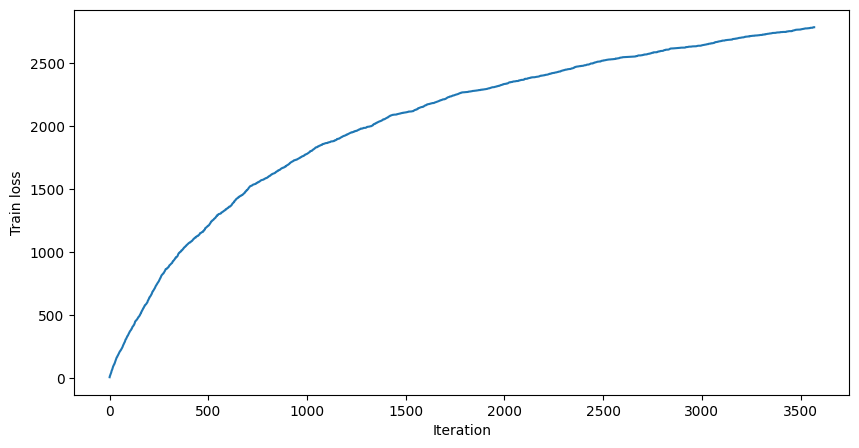

357it [02:48,  2.12it/s]                         


In [118]:
random.seed(SEED)
spacy.util.fix_random_seed(SEED)
optimizer = nlp.begin_training()

#tokenize_train = [nlp.tokenizer(text) for text in X_train]

iter_i = 1
losse = {}
all_losses = []
for epoch in range(10):
    random.shuffle(train_data)
    batches = minibatch(train_data, size=BATCH_SIZE)
    bathes_num = len(train_data) // BATCH_SIZE
    with tqdm(total=bathes_num) as pbar:
        for i, batch in enumerate(batches):
            for text, labels in batch:
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, labels)
                nlp.update([example],
                           sgd=optimizer,
                           losses=losse)        
        
            all_losses.append(losse['textcat'])        
            if iter_i % 10 == 0:
                plot_maker(epoch, iter_i, all_losses)            
            iter_i += 1
            pbar.update(1)

In [120]:
tokenize_test = [nlp.tokenizer(text) for text in X_test]
textcat = nlp.get_pipe('textcat')
scores = textcat.predict(tokenize_test)

In [124]:
roc_auc_score(y_test.values.tolist(), scores[:, 1])

0.9688177872522373

In [131]:
accuracy_score(y_test.values.tolist(), scores.argmax(axis=1))

0.9357084357084358

У нас есть очевидный фаворит в виде SpyCy, однако процесс обучения модели довольно долгий, и из более примитивной модели можно выделить модель [на TF-IDF](#Модель-на-TF-IDF)

# Gen Test File

In [152]:
spam_test_series = _spam_test.squeeze()

tokenize_test = [nlp.tokenizer(text) for text in spam_test_series]
textcat = nlp.get_pipe('textcat')
scores = textcat.predict(tokenize_test)

pred = scores.argmax(axis=1)
test_labels = [textcat.labels[label] for label in pred]

submission_score_df = pd.DataFrame({'score': scores[:, 1], 'text': spam_test_series})
submission_score_df.to_csv('submission_score.csv', index=False)

submission_label_df = pd.DataFrame({'text_type': test_labels, 'text': spam_test_series})
submission_label_df.to_csv('submission_label.csv', index=False)

In [144]:
# spam_train_series = _spam_train['text'].squeeze()

# tokenize_train = [nlp.tokenizer(text) for text in spam_train_series]
# textcat = nlp.get_pipe('textcat')
# scores = textcat.predict(tokenize_train)

# pred = scores.argmax(axis=1)
# train_labels = [textcat.labels[label] for label in pred]

# train_df = pd.DataFrame({'text_type': train_labels, 'text': spam_train_series})
# train_df.to_csv('train_label.csv', index=False)